In [1]:
import tensorflow as tf
import sklearn as sk
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, log_loss, recall_score, ConfusionMatrixDisplay, confusion_matrix, auc
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from keras.applications import Xception, VGG19
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import Input, Model
from keras.optimizers import Adam

# Set constants
IMAGE_SIZE = 64
DATA_PATH = "./asl/asl_alphabet_train/asl_alphabet_train"
RANDOM_STATE = 1
MAX_IMAGES_PER_CLASS = 1000

# Set random seed
tf.random.set_seed(RANDOM_STATE)

In [2]:
def preprocess_data(filepath: str):
    
    # Init output data
    x_data = []
    y_data = []
    
    # For each class folder
    for label in os.listdir(filepath):

        # Initialize variables to retrieve and store images
        curr_path = filepath + "/" + label

        # For each image
        for filename in tqdm.tqdm(os.listdir(curr_path)[:MAX_IMAGES_PER_CLASS]):

            # Store image in tensor representation
            image_path = curr_path + "/" + filename
            image_file = cv2.imread(image_path)
            image_tensor = cv2.resize(image_file, (IMAGE_SIZE, IMAGE_SIZE))
            assert(image_tensor.shape == (IMAGE_SIZE, IMAGE_SIZE, 3))

            # Add tensor to data dictionary
            x_data.append(image_tensor.astype('float32') / 255.0)
            y_data.append(label)

            # debugging
            # plt.imshow(image_tensor / 255.0)
            # plt.show()
            
    # Encode labels
    encoder = OneHotEncoder()
    y_data_enc = encoder.fit_transform(np.array(y_data).reshape(-1, 1)).toarray()
    
    return np.array(x_data), y_data_enc, encoder

In [3]:
# Preprocess all image data
x, y, encoder = preprocess_data(DATA_PATH)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.45it/s]


In [4]:
# Compute average pixel values
x_avgs = []
y_decoded = encoder.inverse_transform(y).reshape(y.shape[0])
x_by_class = {}
x_avgs_by_class = []
for cls in encoder.categories_[0]:
    x_by_class[cls] = []

index = 0
for entry in x:
    x_avgs.append(np.average(entry))
    x_by_class[y_decoded[index]].append(entry)
    index += 1
    
for cls in x_by_class:
    x_avgs_by_class.append(np.average(x_by_class[cls]))

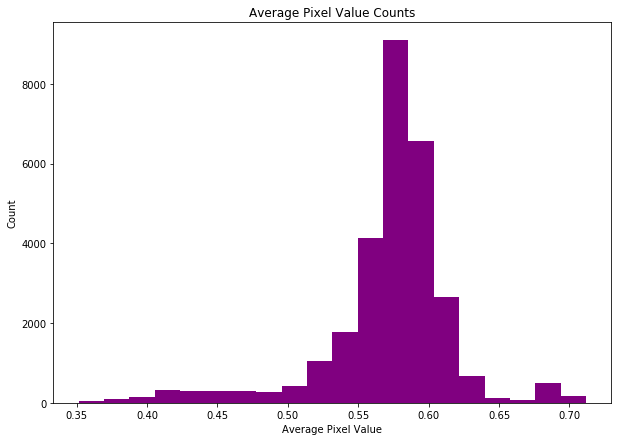

In [5]:
# Plot histogram for average pixel values
plt.figure(figsize=(10, 7))
plt.hist(x_avgs, color='purple', bins=20)
plt.title("Average Pixel Value Counts")
plt.xlabel("Average Pixel Value")
plt.ylabel("Count")
plt.show()

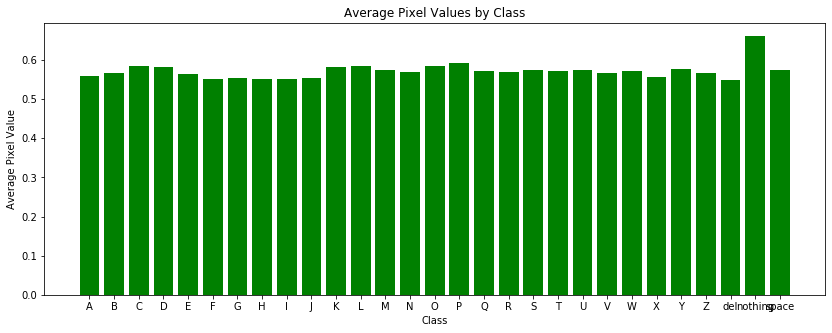

In [6]:
# Plot histogram for average pixel values
plt.figure(figsize=(14, 5))
plt.bar(encoder.categories_[0], height=x_avgs_by_class, color='green')
plt.title("Average Pixel Values by Class")
plt.xlabel("Class")
plt.ylabel("Average Pixel Value")
plt.show()

In [7]:
# Split the data into testing and training inputs and labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, 
                                                    random_state=RANDOM_STATE)

# Print shapes of datasets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(21750, 64, 64, 3) (7250, 64, 64, 3) (21750, 29) (7250, 29)


In [8]:
# Can use labels for logistic regression
log_reg_y_train = encoder.inverse_transform(y_train).reshape(y_train.shape[0])
log_reg_y_test = encoder.inverse_transform(y_test).reshape(y_test.shape[0])

# X tensor must be flattened into 12288 length input
log_reg_x_train = x_train.reshape(x_train.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3)
log_reg_x_test = x_test.reshape(x_test.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3)
print(log_reg_y_train.shape, log_reg_x_train.shape)

# Multinomial Logistic Regression
# Parameters:
# saga solver
# 0.01 tolerance
model_a = LogisticRegression(multi_class='multinomial', solver="saga", tol=0.01, random_state=RANDOM_STATE)

(21750,) (21750, 12288)


In [9]:
model_a.fit(log_reg_x_train, log_reg_y_train)

LogisticRegression(multi_class='multinomial', random_state=1, solver='saga',
                   tol=0.01)

In [10]:
model_a.n_iter_

array([45])

0.4873150843361803
0.9207816091954023
0.9225749645814605
0.9207816091954023


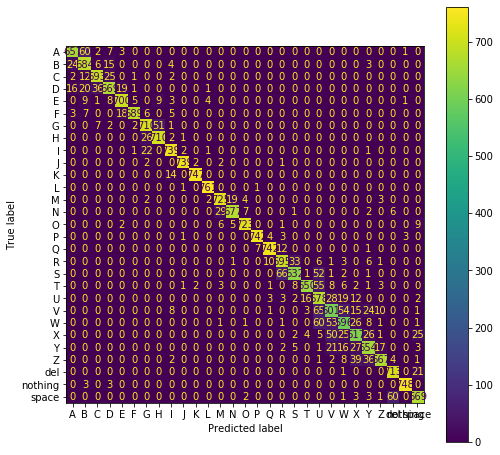

In [11]:
# For training set
# Make predictions using logistic regression model
log_reg_y_pred = model_a.predict(log_reg_x_train)
log_reg_y_pred_probs = model_a.predict_proba(log_reg_x_train)

# print cross entropy loss, accuracy, precision, and recall 
print(log_loss(log_reg_y_train, log_reg_y_pred_probs))
print(accuracy_score(log_reg_y_train, log_reg_y_pred))
print(precision_score(log_reg_y_train, log_reg_y_pred, average='weighted'))
print(recall_score(log_reg_y_train, log_reg_y_pred, average='weighted'))

# display confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(log_reg_y_train, log_reg_y_pred)
ConfusionMatrixDisplay(cm, display_labels=model_a.classes_).plot(ax=ax)
plt.show()

0.5564289161946067
0.887448275862069
0.8900156147822919
0.887448275862069


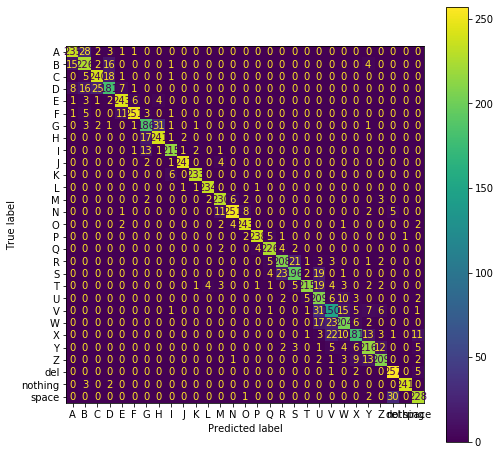

In [12]:
# For testing set
# Making predictions using logistic regression model
log_reg_y_pred = model_a.predict(log_reg_x_test)
log_reg_y_pred_probs = model_a.predict_proba(log_reg_x_test)

# print cross entropy loss, accuracy, precision, and recall
print(log_loss(log_reg_y_test, log_reg_y_pred_probs))
print(accuracy_score(log_reg_y_test, log_reg_y_pred))
print(precision_score(log_reg_y_test, log_reg_y_pred, average='weighted'))
print(recall_score(log_reg_y_test, log_reg_y_pred, average='weighted'))

# Print confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(log_reg_y_test, log_reg_y_pred)
ConfusionMatrixDisplay(cm, display_labels=model_a.classes_).plot(ax=ax)
plt.show()

In [13]:
# Construct model b
model_b = Sequential()
model_b.add(Conv2D(10, (10, 10), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_b.add(MaxPooling2D((3, 3)))
model_b.add(Conv2D(10, (5, 5), activation='relu'))
model_b.add(MaxPooling2D((2, 2)))
model_b.add(Conv2D(10, (3, 3), activation='relu'))
model_b.add(Flatten())
model_b.add(Dense(64, activation='relu'))
model_b.add(Dense(29, activation='softmax'))
model_b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 10)        3010      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        2510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 10)          910       
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [14]:
# compile model b
model_b.compile(loss="categorical_crossentropy", metrics=[CategoricalAccuracy(), Precision(), Recall()])

In [15]:
model_b_history = model_b.fit(x=x_train, y=y_train, epochs=20, verbose=2, validation_data=(x_test, y_test))

Epoch 1/20
680/680 - 24s - loss: 2.6253 - categorical_accuracy: 0.2166 - precision: 0.7743 - recall: 0.0685 - val_loss: 2.1274 - val_categorical_accuracy: 0.3337 - val_precision: 0.6911 - val_recall: 0.1950
Epoch 2/20
680/680 - 24s - loss: 1.5892 - categorical_accuracy: 0.4887 - precision: 0.8170 - recall: 0.3170 - val_loss: 1.2258 - val_categorical_accuracy: 0.6091 - val_precision: 0.8383 - val_recall: 0.4276
Epoch 3/20
680/680 - 26s - loss: 1.0745 - categorical_accuracy: 0.6440 - precision: 0.8376 - recall: 0.5103 - val_loss: 0.8493 - val_categorical_accuracy: 0.7261 - val_precision: 0.8667 - val_recall: 0.6153
Epoch 4/20
680/680 - 27s - loss: 0.7895 - categorical_accuracy: 0.7373 - precision: 0.8652 - recall: 0.6446 - val_loss: 0.9647 - val_categorical_accuracy: 0.6954 - val_precision: 0.7850 - val_recall: 0.6396
Epoch 5/20
680/680 - 25s - loss: 0.6030 - categorical_accuracy: 0.7960 - precision: 0.8810 - recall: 0.7327 - val_loss: 0.6827 - val_categorical_accuracy: 0.7732 - val_prec

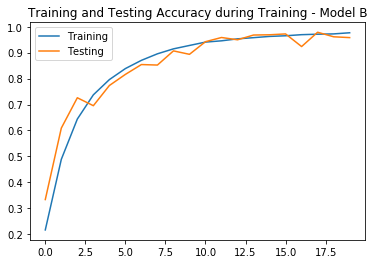

In [16]:
plt.plot(model_b_history.history["categorical_accuracy"])
plt.plot(model_b_history.history["val_categorical_accuracy"])
plt.legend(["Training", "Testing"])
plt.title("Training and Testing Accuracy during Training - Model B")
plt.show()

In [17]:
model_b.evaluate(x_train, y_train, verbose=1)

525/680 [======================>.......] - ETA: 0s - loss: 0.0545 - categorical_accuracy: 0.9688 - precision: 0.9688 - recall: 0.968 - ETA: 4s - loss: 0.0970 - categorical_accuracy: 0.9598 - precision: 0.9640 - recall: 0.955 - ETA: 5s - loss: 0.0944 - categorical_accuracy: 0.9519 - precision: 0.9564 - recall: 0.949 - ETA: 5s - loss: 0.0911 - categorical_accuracy: 0.9589 - precision: 0.9619 - recall: 0.955 - ETA: 5s - loss: 0.1056 - categorical_accuracy: 0.9600 - precision: 0.9623 - recall: 0.957 - ETA: 5s - loss: 0.1036 - categorical_accuracy: 0.9627 - precision: 0.9646 - recall: 0.960 - ETA: 5s - loss: 0.1015 - categorical_accuracy: 0.9637 - precision: 0.9652 - recall: 0.961 - ETA: 5s - loss: 0.1015 - categorical_accuracy: 0.9622 - precision: 0.9635 - recall: 0.960 - ETA: 5s - loss: 0.1026 - categorical_accuracy: 0.9629 - precision: 0.9647 - recall: 0.960 - ETA: 5s - loss: 0.0979 - categorical_accuracy: 0.9641 - precision: 0.9657 - recall: 0.962 - ETA: 5s - loss: 0.0911 - categorical_

680/680 [==============================] - ETA: 1s - loss: 0.1005 - categorical_accuracy: 0.9674 - precision: 0.9688 - recall: 0.965 - ETA: 1s - loss: 0.1007 - categorical_accuracy: 0.9674 - precision: 0.9688 - recall: 0.965 - ETA: 1s - loss: 0.1007 - categorical_accuracy: 0.9674 - precision: 0.9688 - recall: 0.965 - ETA: 1s - loss: 0.0999 - categorical_accuracy: 0.9676 - precision: 0.9691 - recall: 0.966 - ETA: 1s - loss: 0.1004 - categorical_accuracy: 0.9674 - precision: 0.9689 - recall: 0.965 - ETA: 1s - loss: 0.1003 - categorical_accuracy: 0.9674 - precision: 0.9690 - recall: 0.965 - ETA: 1s - loss: 0.1008 - categorical_accuracy: 0.9674 - precision: 0.9690 - recall: 0.965 - ETA: 0s - loss: 0.1020 - categorical_accuracy: 0.9670 - precision: 0.9686 - recall: 0.965 - ETA: 0s - loss: 0.1015 - categorical_accuracy: 0.9671 - precision: 0.9687 - recall: 0.965 - ETA: 0s - loss: 0.1014 - categorical_accuracy: 0.9671 - precision: 0.9688 - recall: 0.965 - ETA: 0s - loss: 0.1013 - categorical_

[0.10149487853050232,
 0.967172384262085,
 0.9689028263092041,
 0.9655172228813171]

In [18]:
model_b.evaluate(x_test, y_test, verbose=1)

227/227 [==============================] - ETA: 0s - loss: 0.2500 - categorical_accuracy: 0.9062 - precision: 0.9062 - recall: 0.906 - ETA: 2s - loss: 0.1348 - categorical_accuracy: 0.9427 - precision: 0.9427 - recall: 0.942 - ETA: 2s - loss: 0.1180 - categorical_accuracy: 0.9505 - precision: 0.9529 - recall: 0.947 - ETA: 1s - loss: 0.0977 - categorical_accuracy: 0.9618 - precision: 0.9634 - recall: 0.960 - ETA: 1s - loss: 0.1000 - categorical_accuracy: 0.9635 - precision: 0.9648 - recall: 0.962 - ETA: 1s - loss: 0.1000 - categorical_accuracy: 0.9646 - precision: 0.9656 - recall: 0.963 - ETA: 1s - loss: 0.1242 - categorical_accuracy: 0.9653 - precision: 0.9661 - recall: 0.963 - ETA: 1s - loss: 0.1171 - categorical_accuracy: 0.9673 - precision: 0.9679 - recall: 0.965 - ETA: 1s - loss: 0.1210 - categorical_accuracy: 0.9642 - precision: 0.9648 - recall: 0.962 - ETA: 1s - loss: 0.1246 - categorical_accuracy: 0.9641 - precision: 0.9652 - recall: 0.962 - ETA: 1s - loss: 0.1244 - categorical_

[0.13819794356822968, 0.9579310417175293, 0.96052086353302, 0.9564138054847717]

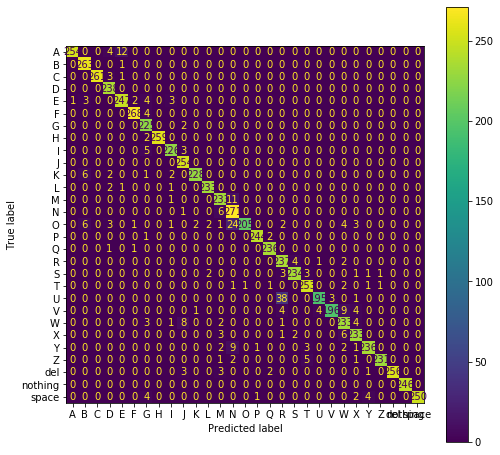

In [19]:
# Print confusion matrix for model b
y_pred = [np.argmax(probs) for probs in model_b.predict(x_test)]
y_true_lbls = encoder.inverse_transform(y_test)
y_true_idxs = [list(encoder.categories_[0]).index(entry) for entry in y_true_lbls]
cm = confusion_matrix(y_true_idxs, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm, display_labels=encoder.categories_[0]).plot(ax=ax)
plt.show()

In [20]:
# initialize model with all layers except top from Xception
model_c_base = Xception(include_top=False,
    input_tensor=Input(shape=(64, 64, 3)))

# Freeze all layers in Xception
for layer in model_c_base.layers:
    layer.trainable = False

# Add the new head for model c
model_c_head = model_c_base.output
model_c_head = Flatten(name="flatten")(model_c_head)
model_c_head = Dense(128, activation="relu")(model_c_head)
model_c_head = Dense(29, activation="softmax")(model_c_head)
model_c = Model(inputs=model_c_base.input, outputs=model_c_head)

# Unfreeze final 6 layers
for i in range(1, 7):
    model_c.layers[-i].trainable = True
    
model_c.compile(loss="categorical_crossentropy",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])

In [21]:
model_c.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 31, 31, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 31, 31, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

block5_sepconv1_bn (BatchNormal (None, 4, 4, 728)    2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 4, 4, 728)    0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 4, 4, 728)    536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 4, 4, 728)    2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 4, 4, 728)    0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 4, 4, 728)    536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 4, 4, 728)    2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 4, 4, 728)    0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 4, 4, 728)    536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 4, 4, 728)    2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 4, 4, 728)    0           add_10[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 4, 4, 728)    536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 4, 4, 728)    2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 4, 4, 728)    0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 4, 4, 1024)   752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [22]:
model_c_history = model_c.fit(x=x_train, y=y_train, epochs=10, verbose=2, validation_data=(x_test, y_test))

Epoch 1/10
680/680 - 182s - loss: 0.4562 - categorical_accuracy: 0.8761 - precision_1: 0.9252 - recall_1: 0.8430 - val_loss: 0.1015 - val_categorical_accuracy: 0.9737 - val_precision_1: 0.9746 - val_recall_1: 0.9727
Epoch 2/10
680/680 - 184s - loss: 0.1103 - categorical_accuracy: 0.9727 - precision_1: 0.9740 - recall_1: 0.9713 - val_loss: 0.0543 - val_categorical_accuracy: 0.9828 - val_precision_1: 0.9833 - val_recall_1: 0.9825
Epoch 3/10
680/680 - 187s - loss: 0.0715 - categorical_accuracy: 0.9832 - precision_1: 0.9837 - recall_1: 0.9826 - val_loss: 0.1047 - val_categorical_accuracy: 0.9851 - val_precision_1: 0.9851 - val_recall_1: 0.9851
Epoch 4/10
680/680 - 190s - loss: 0.0685 - categorical_accuracy: 0.9851 - precision_1: 0.9857 - recall_1: 0.9848 - val_loss: 0.0399 - val_categorical_accuracy: 0.9920 - val_precision_1: 0.9920 - val_recall_1: 0.9920
Epoch 5/10
680/680 - 185s - loss: 0.0470 - categorical_accuracy: 0.9900 - precision_1: 0.9903 - recall_1: 0.9899 - val_loss: 0.0330 - va

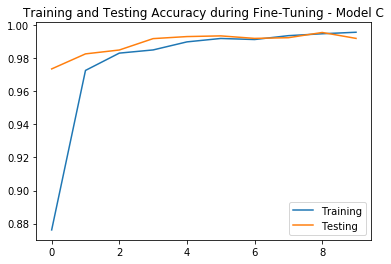

In [23]:
plt.plot(model_c_history.history["categorical_accuracy"])
plt.plot(model_c_history.history["val_categorical_accuracy"])
plt.legend(["Training", "Testing"])
plt.title("Training and Testing Accuracy during Fine-Tuning - Model C")
plt.show()

In [24]:
model_c.evaluate(x_train, y_train, verbose=2)

680/680 - 86s - loss: 0.0270 - categorical_accuracy: 0.9973 - precision_1: 0.9974 - recall_1: 0.9973


[0.026976829394698143,
 0.9973333477973938,
 0.9973791837692261,
 0.9973333477973938]

In [25]:
model_c.evaluate(x_test, y_test, verbose=2)

227/227 - 29s - loss: 0.0738 - categorical_accuracy: 0.9921 - precision_1: 0.9921 - recall_1: 0.9921


[0.07382051646709442,
 0.9921379089355469,
 0.9921379089355469,
 0.9921379089355469]

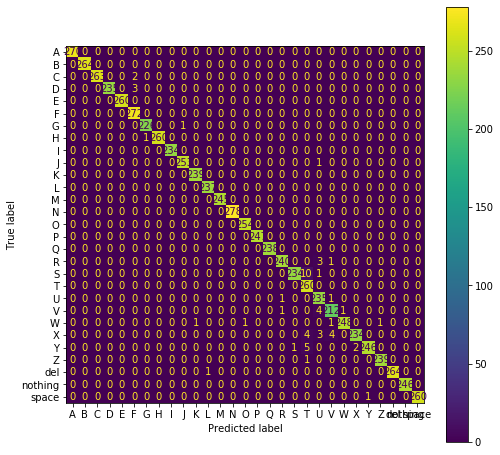

In [26]:
# Print confusion matrix for model c
y_pred = [np.argmax(probs) for probs in model_c.predict(x_test)]
y_true_lbls = encoder.inverse_transform(y_test)
y_true_idxs = [list(encoder.categories_[0]).index(entry) for entry in y_true_lbls]
cm = confusion_matrix(y_true_idxs, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm, display_labels=encoder.categories_[0]).plot(ax=ax)
plt.show()

In [27]:
# initialize model with all layers except top from VGG19
model_d_base = VGG19(include_top=False,
    input_tensor=Input(shape=(64, 64, 3)))

# Freeze all layers in VGG19
for layer in model_d_base.layers:
    layer.trainable = False

# Add the new head for model c
model_d_head = model_d_base.output
model_d_head = Flatten(name="flatten")(model_d_head)
model_d_head = Dense(128, activation="relu")(model_d_head)
model_d_head = Dense(29, activation="softmax")(model_d_head)
model_d = Model(inputs=model_d_base.input, outputs=model_d_head)

# Unfreeze final 5 layers
for i in range(1, 6):
    model_d.layers[-i].trainable = True
    
model_d.compile(loss="categorical_crossentropy", metrics=[CategoricalAccuracy(), Precision(), Recall()])

In [28]:
model_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [29]:
# train model d
model_d_history = model_d.fit(x=x_train, y=y_train, epochs=10, verbose=2, validation_data=(x_test, y_test))

Epoch 1/10
680/680 - 269s - loss: 0.7654 - categorical_accuracy: 0.7732 - precision_2: 0.8861 - recall_2: 0.7149 - val_loss: 0.1378 - val_categorical_accuracy: 0.9461 - val_precision_2: 0.9568 - val_recall_2: 0.9388
Epoch 2/10
680/680 - 267s - loss: 0.1535 - categorical_accuracy: 0.9492 - precision_2: 0.9551 - recall_2: 0.9457 - val_loss: 0.5939 - val_categorical_accuracy: 0.8596 - val_precision_2: 0.8662 - val_recall_2: 0.8556
Epoch 3/10
680/680 - 268s - loss: 0.1041 - categorical_accuracy: 0.9699 - precision_2: 0.9717 - recall_2: 0.9686 - val_loss: 0.1029 - val_categorical_accuracy: 0.9686 - val_precision_2: 0.9711 - val_recall_2: 0.9674
Epoch 4/10
680/680 - 268s - loss: 0.0841 - categorical_accuracy: 0.9766 - precision_2: 0.9774 - recall_2: 0.9761 - val_loss: 0.0751 - val_categorical_accuracy: 0.9788 - val_precision_2: 0.9793 - val_recall_2: 0.9779
Epoch 5/10
680/680 - 269s - loss: 0.0692 - categorical_accuracy: 0.9828 - precision_2: 0.9833 - recall_2: 0.9823 - val_loss: 0.1275 - va

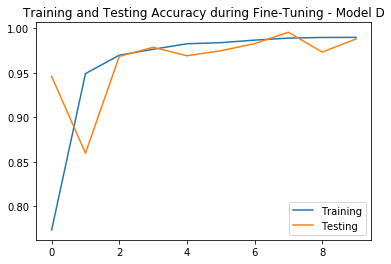

In [30]:
# display accuracy over time
plt.plot(model_d_history.history["categorical_accuracy"])
plt.plot(model_d_history.history["val_categorical_accuracy"])
plt.legend(["Training", "Testing"])
plt.title("Training and Testing Accuracy during Fine-Tuning - Model D")
plt.show()

In [31]:
model_d.evaluate(x_train, y_train, verbose=2)

680/680 - 182s - loss: 0.0343 - categorical_accuracy: 0.9916 - precision_2: 0.9917 - recall_2: 0.9916


[0.03426244482398033,
 0.9915862083435059,
 0.9917230010032654,
 0.9915862083435059]

In [32]:
model_d.evaluate(x_test, y_test, verbose=2)

227/227 - 60s - loss: 0.0543 - categorical_accuracy: 0.9881 - precision_2: 0.9884 - recall_2: 0.9881


[0.05429188534617424, 0.98813796043396, 0.9884105920791626, 0.98813796043396]

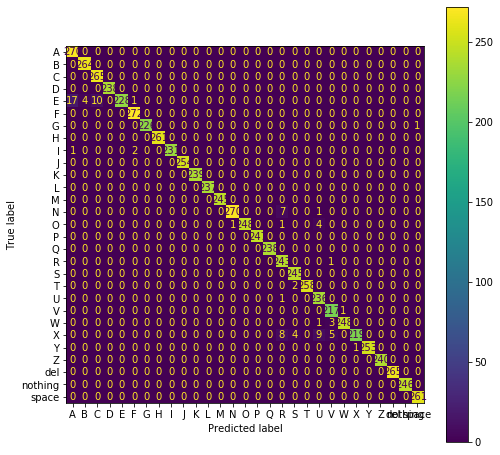

In [33]:
# display confusion matrix for model d
y_pred = [np.argmax(probs) for probs in model_d.predict(x_test)]
y_true_lbls = encoder.inverse_transform(y_test)
y_true_idxs = [list(encoder.categories_[0]).index(entry) for entry in y_true_lbls]
cm = confusion_matrix(y_true_idxs, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm, display_labels=encoder.categories_[0]).plot(ax=ax)
plt.show()